### Initial Imports 

In [0]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import os
import time
from sklearn import preprocessing
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[1] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
  


Populating the interactive namespace from numpy and matplotlib
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `pip install -q http://download.pytorch.org/whl/	libcudart.so (libc6,x86-64) => /usr/local/cuda-9.2/targets/x86_64-linux/lib/libcudart.so/torch-0.4.1-cp36-cp36m-linux_x86_64.whl torchvision'


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
# http://pytorch.org/
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pickle
from torch.utils.data.sampler import (SubsetRandomSampler,
                                      RandomSampler)
from torchvision import datasets, transforms


In [0]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cuda


In [0]:

#torch.cuda.is_available()

### Loading Data From Drive

In [0]:
## !!! Need to ge rid of first row, then tell loader there are some strings

full_data = pd.read_csv(
    "/content/drive/My Drive/ml_project/data/adult.csv",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python', skiprows=1,
        na_values="?", dtype={0:int, 1:str, 2:int, 3:str, 4:int, 5: str, 6:str , 7:str ,8:str ,9: str, 10:int, 11:int, 12:int, 13:str,14: str})

print('Dataset size: ', full_data.shape[0])

Dataset size:  48842


#### Optional routine to keep ONLY people from United-States

In [0]:
# Keep only Freedom People
#full_data = full_data[full_data.Country == 'United-States']

# Then drop Column
#full_data = full_data.drop(['Country'], axis=1)

In [0]:
print(full_data.head())
print(full_data.shape)

   Age  Workclass  fnlwgt     Education  Education-Num      Martial Status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18        nan  103497  Some-college             10       Never-married   

          Occupation Relationship   Race     Sex  Capital Gain  Capital Loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                nan    Own-child  White  Female             0             0   

   Hours per week        Country Target  
0       

#### Deletes all rows where a value == 'nan'

In [0]:
# a swiss knife tool for separating string columns to separate list and numerical to separate list

str_list=[]

for data in [full_data]:
    for colname, colvalue in data.iteritems(): 
        if type(colvalue[1]) == str:
            str_list.append(colname) 
num_list = data.columns.difference(str_list)

In [0]:
# replace '?' with NaN, then delete those rows

full_size = full_data.shape[0]
print('Dataset size Before pruning: ', full_size)
for data in [full_data]:
    for i in full_data:
        data[i].replace('nan', np.nan, inplace=True)
    data.dropna(inplace=True)
real_size = full_data.shape[0]
print('Dataset size after pruning: ', real_size)
print('We eliminated ', (full_size-real_size), ' datapoints')

Dataset size Before pruning:  48842
Dataset size after pruning:  45222
We eliminated  3620  datapoints


In [0]:
full_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


#### Take labels out and encode them

In [0]:
# Take
full_labels = full_data['Target'].copy()
print(full_labels.shape[0])

full_data = full_data.drop(['Target'], axis=1)
print(full_data.shape[0])

# Label Encode Labels
label_encoder = LabelEncoder()
full_labels = label_encoder.fit_transform(full_labels)
print(full_labels[:10])

45222
45222
[0 0 1 1 0 1 0 0 1 0]


#### Deal with categorical variables 

Here I will use integer encoding on variables that I want the model to assume some form of linear dependance between variables.
It can be adjusted later, but for now I decided on: <br>
<ul>
  

In [0]:
# Segment categorical and non categorical data (will manipulate cat_data, and append them back later)
cat_data = full_data.select_dtypes(include=['object']).copy()
other_data = full_data.select_dtypes(include=['int']).copy()
print(cat_data.head())
print(cat_data.shape)
print(other_data.shape)

   Workclass     Education      Martial Status         Occupation  \
0    Private          11th       Never-married  Machine-op-inspct   
1    Private       HS-grad  Married-civ-spouse    Farming-fishing   
2  Local-gov    Assoc-acdm  Married-civ-spouse    Protective-serv   
3    Private  Some-college  Married-civ-spouse  Machine-op-inspct   
5    Private          10th       Never-married      Other-service   

    Relationship   Race   Sex        Country  
0      Own-child  Black  Male  United-States  
1        Husband  White  Male  United-States  
2        Husband  White  Male  United-States  
3        Husband  Black  Male  United-States  
5  Not-in-family  White  Male  United-States  
(45222, 8)
(45222, 6)


##### Then One Hot encode other Categorical Variables

In [0]:
newcat_data = pd.get_dummies(cat_data, columns=[
    "Workclass", "Education", "Country" ,"Relationship", "Martial Status", "Occupation", "Relationship",
    "Race", "Sex"
])

In [0]:
newcat_data.head()

,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Education_10th,Education_11th,Education_12th,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Amer-Indian-Eskimo,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Female,Sex_Male
0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
5,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1


##### Append all columns back together

In [0]:
full_data = pd.concat([other_data, newcat_data], axis=1)

In [0]:
print(full_data.head())

   Age  fnlwgt  Education-Num  Capital Gain  Capital Loss  Hours per week  \
0   25  226802              7             0             0              40   
1   38   89814              9             0             0              50   
2   28  336951             12             0             0              40   
3   44  160323             10          7688             0              40   
5   34  198693              6             0             0              30   

   Workclass_Federal-gov  Workclass_Local-gov  Workclass_Private  \
0                      0                    0                  1   
1                      0                    0                  1   
2                      0                    1                  0   
3                      0                    0                  1   
5                      0                    0                  1   

   Workclass_Self-emp-inc    ...     Relationship_Own-child  \
0                       0    ...                          1   
1 

#### Split Data and Target, then train / valid / test set 

In [0]:
# Given 45222 datapoints, 
train_size = 30000
valid_size = 10000
# test_size is the remainder

In [0]:
train_x = full_data.iloc[:train_size, :]
train_y = full_labels[:train_size]
print(train_x.shape)
print(train_y.shape)
print()

valid_x = full_data.iloc[train_size:(train_size+valid_size), :]
valid_y = full_labels[train_size:(train_size+valid_size)]
print(valid_x.shape)
print(valid_y.shape)
print()

test_x = full_data.iloc[(train_size+valid_size):, :]
test_y = full_labels[(train_size+valid_size):]
print(test_x.shape)
print(test_y.shape)
num_features = test_x.shape[1]

(30000, 110)
(30000,)

(10000, 110)
(10000,)

(5222, 110)
(5222,)


In [0]:
print(train_y[:25])

[0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0]


In [0]:
num_features


110

### Neural Net

#### Prep Data for Dataloader

In [0]:
directory = os.path.dirname('./data_ML/')

try:
    os.stat(directory)
except:
    os.mkdir(directory)  

In [0]:
import os, shutil
folder = './data_ML/'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

!ls "./data_ML/"

In [0]:
##############################################################################3
###################### NPY FILES ####################

## Empty directory
full_dataset = np.asarray(full_data).astype(np.float32)
z=0

# load data for dataloader
start = time.time()
for x in range(full_dataset.shape[0]):
    for y in range(2):
        if full_labels[x] == y: 
            temp = (full_dataset[x,:])
            
            directory = './data_ML/' + str(label_encoder.classes_[y])
            if not os.path.exists(directory):
                os.makedirs(directory)
            
            
            np.save((directory+ '/' +str(z) +'.npy'), temp)
            
            z += 1
    
end = time.time()

print('Time to process: ', end-start)
print(z, ' datapoints saved to path')

Time to process:  15.842331647872925
45222  datapoints saved to path


#### Dataloader

In [0]:
mean = np.zeros(num_features)
std_mean = np.ones(num_features)


class prep_stuff:
    def __init__(self, batch_size, path):
        self.batch_size = batch_size
        self.path = path

        batch_size_eval = 128
          
        self.train_data = datasets.DatasetFolder(self.path, np.load, ('npy') 
                               )
   
        
        indices = list(range(len(self.train_data)))
        random.shuffle(indices)

        # Split dataset into train and Test sets
        self.train_loader = DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            sampler=SubsetRandomSampler(indices[:30001]),
            num_workers=1,
        )

        self.valid_loader = DataLoader(
            self.train_data,
            batch_size=batch_size_eval,
            sampler=SubsetRandomSampler(indices[30001:38001]),
            num_workers=1,
        )

        self.test_loader = DataLoader(
            self.train_data,
            batch_size=batch_size_eval,
            sampler=SubsetRandomSampler(indices[38001:]),
            num_workers=1,
        )
        
           


# Create the object with both loader and loss functions

batchSize = 1000
path = './data_ML/'

# 30 000 for train
# 8 000 for valid 
# 3200 for Test
pre_model = prep_stuff(batchSize, path)


In [0]:
pre_model.train_data

Dataset DatasetFolder
    Number of datapoints: 45222
    Root Location: ./data_ML/
    Transforms (if any): None
    Target Transforms (if any): None

In [0]:
class BasicNet(nn.Module):
    
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.num_classes = num_classes
        self.layers = 0
        
        self.lin1 = torch.nn.Linear(self.num_features,  150)        
        self.lin2 = torch.nn.Linear(50, 50)        
        self.lin3 = torch.nn.Linear(50, 50)
        
        self.lin4 = torch.nn.Linear(150, 150) 
        
        self.lin5 = torch.nn.Linear(50, 50)        
        self.lin6 = torch.nn.Linear(50, 50)
        self.lin10 = torch.nn.Linear(150, self.num_classes)
        
        self.prelu = nn.PReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, xin):
        self.layers = 0
        
        x = F.relu(self.lin1(xin))
        self.layers += 1
        
        #x = F.relu(self.lin2(x))
        #self.layers += 1
        for y in range(8):
          x = F.relu(self.lin4(x)) 
          self.layers += 1
           
        x = self.dropout(x)
        
        x = F.relu(self.lin10(x)) 
        self.layers += 1
        return x
      

In [0]:


def train(model, train_loader, optimizer, epoch):
    model.train()
    
    for inputs, target in train_loader:
      
        inputs, target = inputs.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target)
        # Backprop
        loss.backward()
        optimizer.step()
        ###

In [0]:
def test(model, test_loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    
    with torch.no_grad():
      
        for inputs, target in test_loader:
            
            inputs, target = inputs.to(device), target.to(device)
            
            output = model(inputs)
            test_size += len(inputs)
            test_loss += test_loss_fn(output, target).item() 
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

In [0]:

model = BasicNet(num_features, 2).to(device)
test_accuracy = []
train_loss = []
nbr_epochs = 100
lr = 0.0025# 
weight_decay = 0



# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr=lr ,weight_decay=weight_decay)
#optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)


print('Training beginning...')
start_time = time.time()

for epoch in range(1, nbr_epochs+1):
    print('Epoch ', epoch, ':')
    train(model, pre_model.train_loader, optimizer, epoch)
    loss, acc = test(model, pre_model.valid_loader)
    
    # save results every epoch
    test_accuracy.append(acc)
    train_loss.append(loss)
    
end_time = time.time()
print('Training on ' + str(nbr_epochs) + ' epochs done in ', str(end_time-start_time),' seconds')

Training beginning...
Epoch  1 :

Test set: Average loss: 0.7173, Accuracy: 5971/8000 (75%)

Epoch  2 :

Test set: Average loss: 0.6194, Accuracy: 5971/8000 (75%)

Epoch  3 :

Test set: Average loss: 0.5455, Accuracy: 5971/8000 (75%)

Epoch  4 :

Test set: Average loss: 0.5731, Accuracy: 5971/8000 (75%)

Epoch  5 :

Test set: Average loss: 0.5501, Accuracy: 6316/8000 (79%)

Epoch  6 :

Test set: Average loss: 0.5378, Accuracy: 6302/8000 (79%)

Epoch  7 :

Test set: Average loss: 0.5250, Accuracy: 6302/8000 (79%)

Epoch  8 :

Test set: Average loss: 0.5047, Accuracy: 6321/8000 (79%)

Epoch  9 :

Test set: Average loss: 0.5259, Accuracy: 6311/8000 (79%)

Epoch  10 :

Test set: Average loss: 0.4974, Accuracy: 6334/8000 (79%)

Epoch  11 :

Test set: Average loss: 0.5043, Accuracy: 6327/8000 (79%)

Epoch  12 :

Test set: Average loss: 0.5044, Accuracy: 6323/8000 (79%)

Epoch  13 :

Test set: Average loss: 0.5009, Accuracy: 6318/8000 (79%)

Epoch  14 :

Test set: Average loss: 0.4926, Accura

With lr= 0.0003 , Batch size of  150  and 
Neural Network has  10  layers and 50 neurons wide
CrossEntropyLoss()


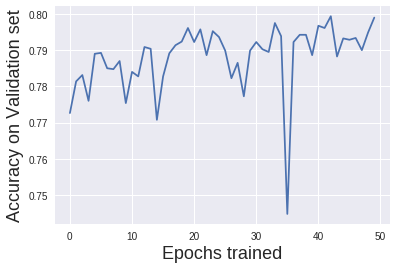

In [0]:
# Accuracy
xvalues= np.arange(0,nbr_epochs,1)
plt.xlabel('Epochs trained', fontsize=18)
plt.ylabel('Accuracy on Validation set', fontsize=18)
plt.plot(xvalues, test_accuracy)

print('With lr=',lr, ', Batch size of ', batchSize ,' and ')
print('Neural Network has ', model.layers, ' layers and 50 neurons wide')
print(loss_fn)

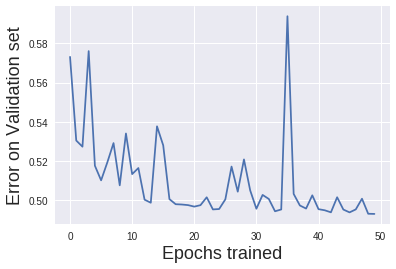

In [0]:
#error
plt.xlabel('Epochs trained', fontsize=18)
plt.ylabel('Error on Validation set', fontsize=18)
plt.plot(xvalues, train_loss)

#### Test Trained model

In [0]:
loss, acc = test(model, pre_model.test_loader)


Test set: Average loss: 0.4850, Accuracy: 5822/7221 (81%)



### Random Forest

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import os
import time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:

k = 10

RFC = RandomForestClassifier(n_estimators=k, random_state=0)

RFC.fit(train_x, train_y)

mean_accuracy = (RFC.score(valid_x, valid_y))

In [0]:
print(mean_accuracy)

0.843


#### K trees optimization

In [0]:
# Use cross validation to find optimal NUMBER of trees for forest

# Here we test values for k from 1000 to 1500, every 50, hence 10 tests
x_axis = np.arange(1,201,5)
RFC_acc = []

t1 = time.time()
for k in range(1,201,5):
    RFC = RandomForestClassifier(n_estimators=k, random_state=0)

    RFC.fit(train_x, train_y)
    
    RFC_acc.append(RFC.score(valid_x, valid_y))
    print('Forest with ', k , ' trees trained.')
t2 = time.time()


Forest with  1  trees trained.
Forest with  6  trees trained.
Forest with  11  trees trained.
Forest with  16  trees trained.
Forest with  21  trees trained.
Forest with  26  trees trained.
Forest with  31  trees trained.
Forest with  36  trees trained.
Forest with  41  trees trained.
Forest with  46  trees trained.
Forest with  51  trees trained.
Forest with  56  trees trained.
Forest with  61  trees trained.
Forest with  66  trees trained.
Forest with  71  trees trained.
Forest with  76  trees trained.
Forest with  81  trees trained.
Forest with  86  trees trained.
Forest with  91  trees trained.
Forest with  96  trees trained.
Forest with  101  trees trained.
Forest with  106  trees trained.
Forest with  111  trees trained.
Forest with  116  trees trained.
Forest with  121  trees trained.
Forest with  126  trees trained.
Forest with  131  trees trained.
Forest with  136  trees trained.
Forest with  141  trees trained.
Forest with  146  trees trained.
Forest with  151  trees trained.

In [0]:
    
print('Accuracy on validation set: ', RFC_acc)
print('Training done in ', t2-t1, ' seconds.')
#print('cross validation average error on train set (8.5k): ', np.average(cv_score))

Accuracy on validation set:  [0.7986, 0.8361, 0.8467, 0.8459, 0.8475, 0.8493, 0.851, 0.8487, 0.8498, 0.8502, 0.8516, 0.8512, 0.8504, 0.8511, 0.8513, 0.852, 0.8524, 0.8518, 0.8514, 0.8513, 0.8515, 0.8517, 0.8531, 0.8524, 0.8528, 0.8526, 0.8524, 0.8535, 0.8533, 0.8541, 0.8528, 0.8529, 0.8521, 0.8532, 0.8529, 0.853, 0.8528, 0.8529, 0.8527, 0.8531]
Training done in  214.0780370235443  seconds.


Text(0,0.5,'Accuracy on validation set')

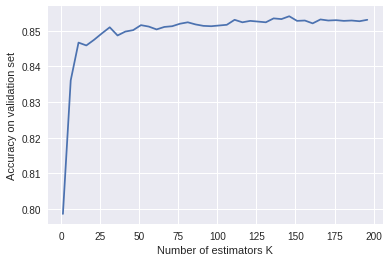

In [0]:
plt.plot(x_axis , RFC_acc)
plt.xlabel('Number of estimators K')
plt.ylabel('Accuracy on validation set')

In [0]:
best_value = (np.argmax(RFC_acc))
print('Best value was found with ', x_axis[best_value], ' trees, at ', RFC_acc[best_value]*100, '% accuracy' )

Best value was found with  146  trees, at  85.41 % accuracy


#### Max Depth optimization

In [0]:
RFC = RandomForestClassifier(n_estimators=146,  max_depth=17 , random_state=0)

RFC.fit(train_x, train_y)

RFC_acc2 = (RFC.score(valid_x, valid_y))

print(RFC_acc2)

0.8615


In [0]:
k_trees = 146

x_ax = [1, 10, 50, 100, 150, 200, 250, 300, 350]
RFC_acc2 = []
for k in range(len(x_ax)):
    RFC = RandomForestClassifier(n_estimators=k_trees,  max_depth=x_ax[k] , random_state=0)

    RFC.fit(train_x, train_y)
    
    RFC_acc2.append(RFC.score(valid_x, valid_y))
    print('Training with max depth of ', x_ax[k] , ' completed.')


Training with max depth of  1  completed.
Training with max depth of  10  completed.
Training with max depth of  50  completed.
Training with max depth of  100  completed.
Training with max depth of  150  completed.
Training with max depth of  200  completed.
Training with max depth of  250  completed.
Training with max depth of  300  completed.
Training with max depth of  350  completed.


Best value was found with max depth of 6 , at  85.72 % accuracy


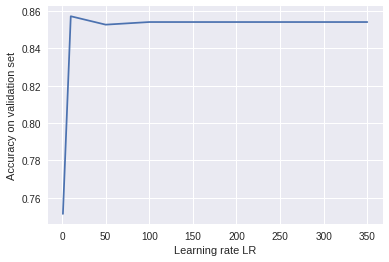

In [0]:
plt.plot(x_ax , RFC_acc2)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy on validation set')

best_value = (np.argmax(RFC_acc2))
print('Best value was found with max depth of', x_axis[best_value], ', at ', RFC_acc2[best_value]*100, '% accuracy' )

#### Tester les deux HP ensemble

In [0]:
RFC_accuracy_matrix = np.zeros((7,10))
cv_score = np.zeros((7,10))
for k in range(7):
    for j in range(1000, 1501 ,50):
        RFC = RandomForestClassifier(n_estimators=j,  max_depth=k , random_state=0)

        RFC.fit(x_train, x_traiy)
    
        RFC_accuracy_matrix[k,j] = RFC.score(valid_x, valid_y)
        #cv_score = cross_val_score(RFC, x_train, y_train , cv=3)

In [0]:
print(RFC_accuracy_matrix)

In [0]:
# Would be nice to have a plot of the two functions


